# Projet : Analyse Exploratoire des Données Économiques Mondiales

## Objectif : Analyser les indicateurs économiques mondiaux pour identifier des tendances et des corrélations.

Ce projet analyse les données économiques mondiales pour comprendre les relations entre différents indicateurs tels que le PIB, la dette publique, et les dépenses en éducation. L'objectif est de trouver des corrélations et de visualiser les différences régionales.

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Étude Comparative des Pays Riches
Analyser si les pays les plus riches sont aussi ceux où le coût de la vie est le plus élevé.

In [7]:

path = "Datasets"
richest_df = pd.read_csv(os.path.join(path, "richest_country.csv"))
cost_df = pd.read_csv(os.path.join(path, "cost_of_living.csv"))

# Aperçu des données
print("Richest Countries:")
print(richest_df.head())
print("\nCost of Living:")
print(cost_df.head())


Richest Countries:
      country  gdp_per_capita
0  Luxembourg          134754
1   Singapore          116486
2     Ireland          106456
3       Qatar           93521
4     Bermuda           85192

Cost of Living:
          country  cost_index  monthly_income  purchasing_power_index
0         Bermuda       157.6            9712                   105.0
1     Switzerland       142.4            7530                    90.1
2  Cayman Islands       137.9            5281                    65.2
3          Israel       130.2            4130                    54.1
4         Iceland       128.0            5368                    71.5


In [ ]:
# Nettoyage des données
richest_df = richest_df.dropna().drop_duplicates()
cost_df = cost_df.dropna().drop_duplicates()


print("\nColonnes - Richest Countries:")
print(richest_df.columns)
print("\nColonnes - Cost of Living:")
print(cost_df.columns)

# Vérification de la cohérence des noms de pays
print("\nPays non communs :")
print(set(richest_df['country']) - set(cost_df['country']))



Colonnes - Richest Countries:
Index(['country', 'gdp_per_capita'], dtype='object')

Colonnes - Cost of Living:
Index(['country', 'cost_index', 'monthly_income', 'purchasing_power_index'], dtype='object')

Pays non communs :
{'Panama', 'Lithuania', 'Slovakia', 'Latvia', 'Cyprus', 'Bahamas', 'Slovenia', 'Oman'}


On constate que le Panama, la Lithuania, la Slovakie, le Latvia, la Chypre, les Bahamas, la Slovenie et le Oman font partis soient des pays les plus riches soient ceux avec le cout de la vie le plus élevé. 

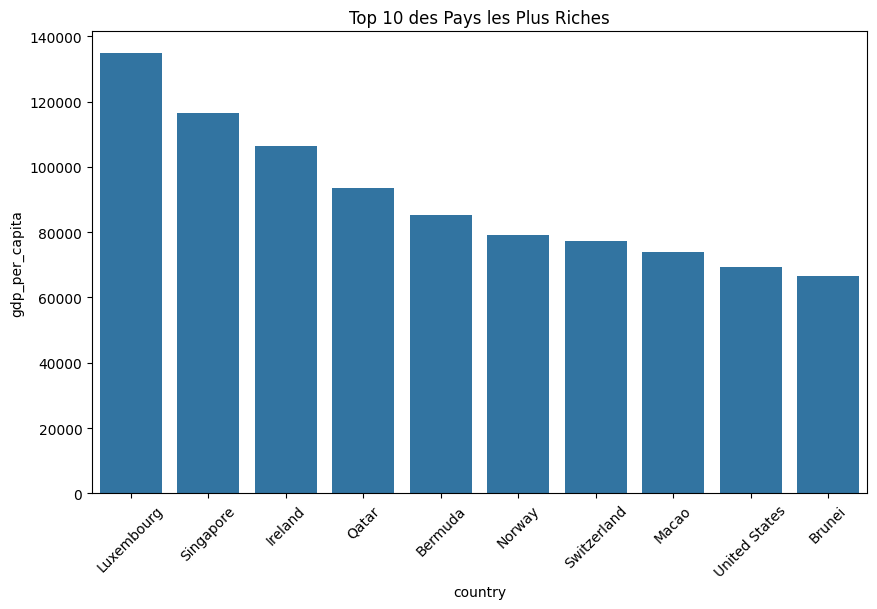

In [12]:
# Tri par PIB par habitant
top10_richest = richest_df.nlargest(10, 'gdp_per_capita')


plt.figure(figsize=(10, 6))
sns.barplot(data=top10_richest, x='country', y='gdp_per_capita')
plt.title('Top 10 des Pays les Plus Riches')
plt.xticks(rotation=45)
plt.show()


Le pays avec le PIB par habitant le plus élevé est le Luxembourg, suivi par Singapour et Irlande.

Les pays du top 10 sont principalement des petites économies développées avec des secteurs financiers puissants ou des ressources naturelles abondantes (comme le Qatar).

Les États-Unis apparaissent dans la liste mais ne sont pas dans le top 5.

Les paradis fiscaux (comme Bermuda et Singapour) contribuent également à ce classement.

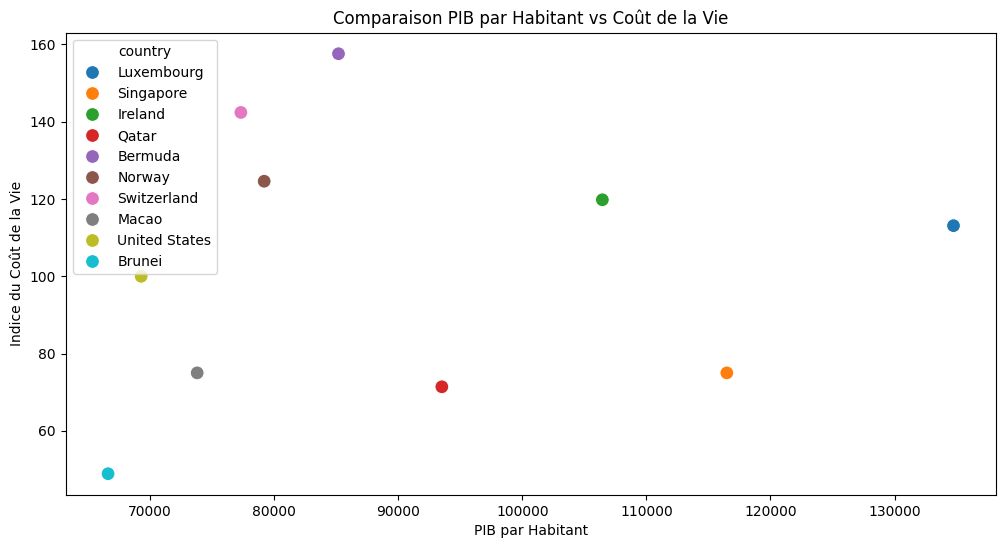

In [14]:

merged_df = pd.merge(richest_df, cost_df, on='country')

top10_merged = merged_df.nlargest(10, 'gdp_per_capita')

# Visualisation comparative
plt.figure(figsize=(12, 6))
sns.scatterplot(data=top10_merged, x='gdp_per_capita', y='cost_index', hue='country', s=100)
plt.title("Comparaison PIB par Habitant vs Coût de la Vie")
plt.xlabel("PIB par Habitant")
plt.ylabel("Indice du Coût de la Vie")
plt.show()


Il n'y a pas de corrélation directe entre la richesse (PIB par habitant) et le coût de la vie parmi ces pays. On a l'exemple de l'Irlande qui a un PIB élevé mais un coût de la vie relativement bas par rapport aux autres.
 
Des facteurs comme la fiscalité ou la dépendance aux importations peuvent influencer les différences.

Corrélation entre PIB et Coût de la Vie : 0.43


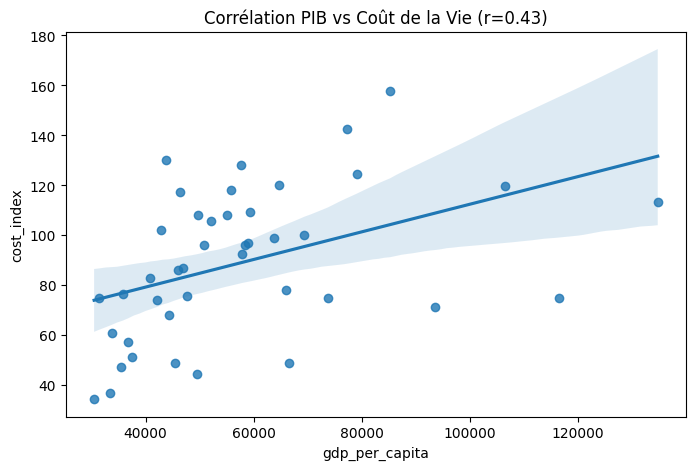

In [15]:

correlation = merged_df['gdp_per_capita'].corr(merged_df['cost_index'])
print(f"Corrélation entre PIB et Coût de la Vie : {correlation:.2f}")

# Visualisation de la corrélation
plt.figure(figsize=(8, 5))
sns.regplot(data=merged_df, x='gdp_per_capita', y='cost_index')
plt.title(f"Corrélation PIB vs Coût de la Vie (r={correlation:.2f})")
plt.show()


Le coefficient de corrélation est de 0.43, ce qui indique une corrélation modérée et positive. Ceci montre que la richesse nationale n'est pas le seul déterminant du coût de la vie.

En général, une augmentation du PIB par habitant est associée à une augmentation du coût de la vie, mais ce n'est pas systématique.

Il existe plusieurs points éloignés de la ligne de régression, suggérant des exceptions ou des facteurs externes.

### Formule écart type

\begin{equation} 
  \sigma = \sqrt{\frac{1}{N}\sum_{i = 1} ^N(x_i-\mu)}
\end{equation} 


Pays atypiques (PIB élevé mais coût faible ou inversement) :
     country  gdp_per_capita  cost_index
1  Singapore          116486        75.0


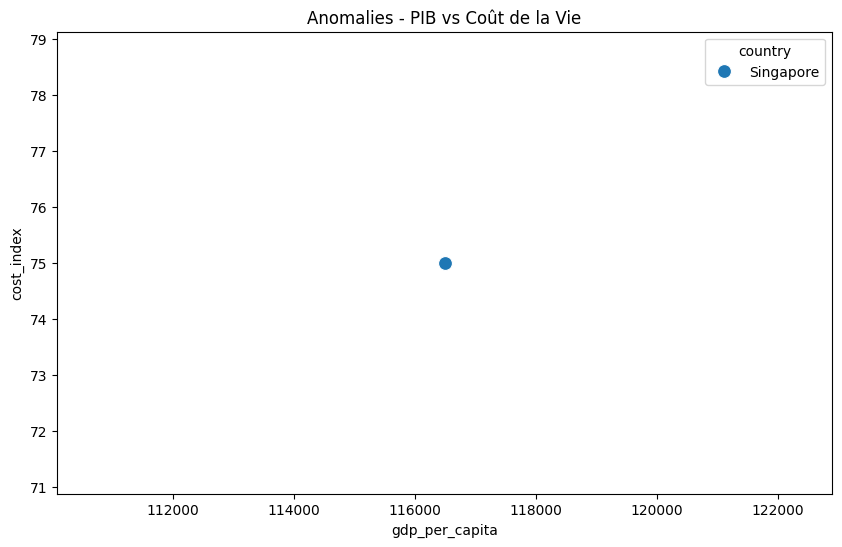

In [ ]:
mean_gdp = merged_df['gdp_per_capita'].mean()
std_gdp = merged_df['gdp_per_capita'].std()
mean_cost = merged_df['cost_index'].mean()
std_cost = merged_df['cost_index'].std()

# Détection des anomalies
anomalies = merged_df[
    ((merged_df['gdp_per_capita'] > mean_gdp + 2 * std_gdp) & (merged_df['cost_index'] < mean_cost)) |
    ((merged_df['gdp_per_capita'] < mean_gdp) & (merged_df['cost_index'] > mean_cost + 2 * std_cost))
]

# Affichage des anomalies
print("Pays atypiques (PIB élevé mais coût faible ou inversement) :")
print(anomalies[['country', 'gdp_per_capita', 'cost_index']])

# Visualisation
plt.figure(figsize=(10, 6))
sns.scatterplot(data=anomalies, x='gdp_per_capita', y='cost_index', hue='country', s=100)
plt.title("Anomalies - PIB vs Coût de la Vie")
plt.show()


Une anomalie est détectée pour Singapour.

Singapour a un PIB par habitant très élevé mais un coût de la vie relativement faible par rapport aux autres pays avec un PIB similaire.

Cela pourrait s'expliquer par des politiques gouvernementales spécifiques ou une économie très ouverte qui réduit certains coûts. Mais aussi, le fait que la ville soit connu pour son rôle de hub financier et commercial, ce qui pourrait compenser le coût de la vie.

## 2. Analyse de la Corrélation entre Corruption et Chômage
Étudier l'impact de la corruption sur le taux de chômage par pays.

## 3. Analyse du Tourisme et de la Richesse
Vérifier si les pays les plus riches attirent également le plus de touristes.

## 4. Indice de Développement Humain : Corrélation entre PIB, Tourisme et Chômage 
Analyser l'impact combiné du PIB, du tourisme et du chômage sur le développement humain.

## 5. Classement des Pays par Qualité de Vie
Créer un indice composite de la qualité de vie en combinant le coût de la vie, la corruption et le taux de chômage.

## 6. Analyse de l'Attractivité Touristique en fonction de la Richesse
 Identifier les pays les plus attractifs pour les touristes en tenant compte de la richesse et du coût de la vie